## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
## load universe_factors
universe = pd.read_csv('factor_data/all_108_zscore.csv')
universe['date'] = pd.to_datetime(universe['trade_date'],format='%Y%m%d')
universe.set_index(['date'],inplace=True)
universe = universe.loc[universe['trade_date']>20190401]
universe = universe.fillna(0.)
universe.head()

,ts_code,trade_date,turnover_rate,pe,pb,ps,dv_ratio,total_share,free_share,total_mv,...,alpha_083,alpha_089,alpha_101,alpha_103,alpha_111,alpha_122,section1,section2,alpha_149,ind_val
date,,,,,,,,,,,,,,,,,,,,,
2019-04-02,002788.SZ,20190402,2.6067,23.5129,1.9547,0.3682,0.8349,19225.3200,17209.2771,307028.3604,...,-0.014666,0.054439,0.0,-0.064623,0.188815,-0.089522,0.0,0.0,-0.165661,1
2019-04-02,002728.SZ,20190402,1.7915,21.6859,3.6708,3.8116,2.9646,20090.3430,7149.4055,337316.8590,...,-0.158393,0.096655,0.0,0.083892,0.030662,-0.041174,0.0,0.0,0.097443,1
2019-04-02,002649.SZ,20190402,7.9732,23.7255,2.1690,1.8246,0.8304,52549.2600,38642.7041,526018.0926,...,-0.023466,-0.030320,0.0,0.514638,0.002275,-0.001655,0.0,0.0,0.077468,0
2019-04-02,002605.SZ,20190402,4.1491,56.7950,2.4366,6.5851,0.9102,39776.9187,11467.0332,436352.7981,...,-0.387183,0.068799,0.0,-0.143456,-0.002134,-0.266394,0.0,0.0,-0.818134,0
2019-04-02,002577.SZ,20190402,1.7972,197.2216,3.1563,7.4484,0.0000,28288.0000,10479.2361,372270.0800,...,0.157534,-0.086155,0.0,0.457888,0.029504,0.278147,0.0,0.0,0.383170,0


### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [3]:
all_factors = universe.copy(deep=True)
universe.industry.unique()

array(['医药商业', '中成药', '软件服务', '互联网', 'IT设备', '化学制药', '生物制药', '医疗保健',
       '化工原料', '元器件', '半导体'], dtype=object)

In [4]:
# sector_dict = {'软件服务':1, '医疗保健':2, '化学制药':3, '中成药':4, 'IT设备':5, '互联网':6, '生物制药':7, '化工原料':8,
#        '医药商业':9, '元器件':10, '半导体':11}
sector_dict = {1:1, 0:0}
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['ind_val']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,pe,pb,ps,dv_ratio,total_share,free_share,total_mv,...,alpha_101,alpha_103,alpha_111,alpha_122,section1,section2,alpha_149,ind_val,sector_1,sector_0
date,,,,,,,,,,,,,,,,,,,,,
2019-04-02,002788.SZ,20190402,2.6067,23.5129,1.9547,0.3682,0.8349,19225.3200,17209.2771,307028.3604,...,0.0,-0.064623,0.188815,-0.089522,0.0,0.0,-0.165661,1,True,False
2019-04-02,002728.SZ,20190402,1.7915,21.6859,3.6708,3.8116,2.9646,20090.3430,7149.4055,337316.8590,...,0.0,0.083892,0.030662,-0.041174,0.0,0.0,0.097443,1,True,False
2019-04-02,002649.SZ,20190402,7.9732,23.7255,2.1690,1.8246,0.8304,52549.2600,38642.7041,526018.0926,...,0.0,0.514638,0.002275,-0.001655,0.0,0.0,0.077468,0,False,True
2019-04-02,002605.SZ,20190402,4.1491,56.7950,2.4366,6.5851,0.9102,39776.9187,11467.0332,436352.7981,...,0.0,-0.143456,-0.002134,-0.266394,0.0,0.0,-0.818134,0,False,True
2019-04-02,002577.SZ,20190402,1.7972,197.2216,3.1563,7.4484,0.0000,28288.0000,10479.2361,372270.0800,...,0.0,0.457888,0.029504,0.278147,0.0,0.0,0.383170,0,False,True


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [5]:
quantile_jud = all_factors['log-ret'].quantile([0.3,0.7,1.])
quantile_jud

0.3   -0.012534
0.7    0.011029
1.0    0.258654
Name: log-ret, dtype: float64

In [6]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<=-0.01, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>=0.01, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [7]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2).fillna(0).astype(np.int16)

In [8]:
all_factors['target'].unique()
#all_factors.loc[all_factors['target']==0].trade_date.unique()

array([ 0,  1, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

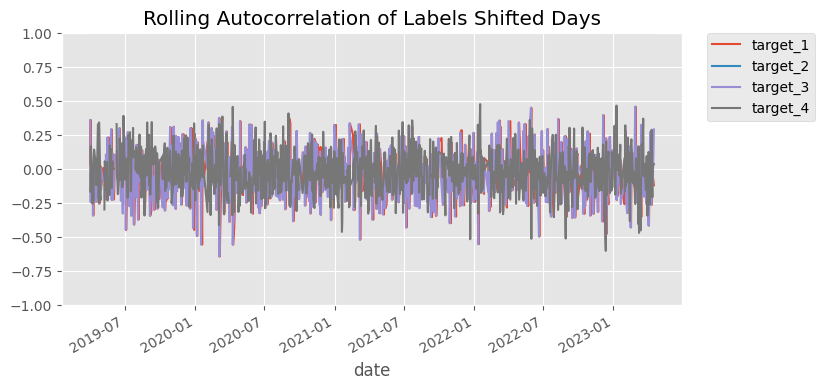

In [9]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220701]
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [10]:
features = [
            'alpha_kama', 'alpha_atr14', 'alpha_083', 'alpha_103',  'alpha_111', 
            'alpha_pb',  'alpha_101', 'alpha_atr', 'alpha_010',  'alpha_supertrend',
            'alpha_056', 'alpha_149', 'alpha_075', 'alpha_089','alpha_122', 'alpha_069', 'alpha_021',
            ] + sector_columns

target_label = 'target'
print(all_factors.shape)

(86593, 73)


In [12]:
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_index(level=['date'])
print(all_factors.shape)
all_factors.head()

(86161, 73)


trade_date  turnover_rate        pe      pb      ps  \
date       ts_code                                                          
2019-04-02 000411.SZ    20190402         3.3493   35.8792  3.2739  0.1584   
           000756.SZ    20190402         2.1743   19.5855  1.8281  0.9433   
           000915.SZ    20190402         3.6041   44.4305  3.6061  3.7755   
           002322.SZ    20190402         2.9820   22.8375  2.1683  7.5718   
           002362.SZ    20190402         4.3341  249.8015  4.6423  5.3032   

                      dv_ratio  total_share  free_share     total_mv  \
date       ts_code                                                     
2019-04-02 000411.SZ    0.0000   20744.9946   9393.7349  299557.7220   
           000756.SZ    0.7790   62185.9447  19463.0985  491268.9631   
           000915.SZ    1.0167   23433.1485  18488.8117  576221.1216   
           002322.SZ    3.0138   39666.2205  20665.0203  637436.1634   
           002362.SZ    0.0000   21703.1292  13245.2747  396299.1392   

                          circ_mv  ... alpha_149 ind_val  sector_1  sector_0  \
date       ts_code                 ...                                         
2019-04-02 000411.SZ  299343.1075  ...  0.374683       1      True     False   
           000756.SZ  315601.1108  ...  0.452280       1      True     False   
           000915.SZ  574010.4118  ... -0.451022       1      True     False   
           002322.SZ  579857.9753  ... -0.307116       0     False      True   
           002362.SZ  324841.3846  ... -0.386572       0     False      True   

                      return_2q  target  target_1  target_2  target_3  \
date       ts_code                                                      
2019-04-02 000411.SZ          1       0      -1.0       0.0       0.0   
           000756.SZ         -1       0       1.0       0.0       1.0   
           000915.SZ          0      -1       0.0      -1.0      -1.0   
           002322.SZ          1       1       1.0       1.0       1.0   
           002362.SZ          0       0       0.0       0.0      -1.0   

                      target_4  
date       ts_code              
2019-04-02 000411.SZ       1.0  
           000756.SZ      -1.0  
           000915.SZ       1.0  
           002322.SZ       1.0  
           002362.SZ       1.0  

[5 rows x 73 columns]

In [15]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.8, 0.15, 0.05)

X_valid.tail()

alpha_kama  alpha_atr14  alpha_083  alpha_103  \
date       ts_code                                                    
2023-02-03 688358.SH   -0.206681    -0.259449   0.115967   0.000000   
           688579.SH    0.677999     0.475181   0.274830   0.000000   
           688589.SH   -0.189065    -0.176621   0.164275   0.027182   
           688655.SH    0.333671     0.697910   0.451552   0.000000   
           688799.SH   -0.033938    -0.106116  -0.025300   0.000000   

                      alpha_111  alpha_pb  alpha_101  alpha_atr  alpha_010  \
date       ts_code                                                           
2023-02-03 688358.SH   0.007531 -0.089399  -1.000000  -0.207781  -0.167049   
           688579.SH  -0.010031 -0.167424  -1.000000   0.507423   0.888831   
           688589.SH   0.009891 -0.446673   0.515726  -0.164537  -0.166766   
           688655.SH  -0.098522  0.114934  -1.000000   0.643860   0.797491   
           688799.SH   0.118430  0.389508  -1.000000  -0.039283  -0.117409   

                      alpha_supertrend  alpha_056  alpha_149  alpha_075  \
date       ts_code                                                        
2023-02-03 688358.SH          0.000469        0.0   0.150054  -0.428571   
           688579.SH          0.000233        0.0  -0.324571   0.400000   
           688589.SH          0.000985        0.0  -0.423921   0.100000   
           688655.SH          0.000733        0.0   0.439306   0.000000   
           688799.SH         -0.009805        0.0   0.097202  -0.142857   

                      alpha_089  alpha_122  alpha_069  alpha_021  sector_1  \
date       ts_code                                                           
2023-02-03 688358.SH  -0.245386   0.078321  -0.082418   0.247243      True   
           688579.SH  -0.294007  -0.133672   0.074669  -0.097035     False   
           688589.SH   0.023177  -0.016819   0.122225   0.249554     False   
           688655.SH  -0.116738  -0.137147  -0.008160  -0.033284     False   
           688799.SH   0.129414   0.255206  -0.315815   0.019568      True   

                      sector_0  
date       ts_code              
2023-02-03 688358.SH     False  
           688579.SH      True  
           688589.SH      True  
           688655.SH      True  
           688799.SH     False

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [16]:
X_train.head()

alpha_kama  alpha_atr14  alpha_083  alpha_103  \
date       ts_code                                                    
2019-04-02 000411.SZ    1.000000     0.594627  -0.328519  -0.175854   
           000756.SZ    0.003269     0.812726   0.075342   0.007223   
           000915.SZ   -0.326267    -0.171746  -0.038132  -0.214365   
           002322.SZ   -0.131119     0.000000  -0.117328  -0.588163   
           002362.SZ   -0.067635    -0.125321   0.047945   0.226140   

                      alpha_111  alpha_pb  alpha_101  alpha_atr  alpha_010  \
date       ts_code                                                           
2019-04-02 000411.SZ   0.010122  0.088319        0.0   0.592951   0.489402   
           000756.SZ  -0.003755  0.962918        0.0   0.762968   0.864553   
           000915.SZ  -0.008015 -0.023046        0.0  -0.188124  -0.113603   
           002322.SZ   0.007981  0.757123        0.0  -0.029508   0.211757   
           002362.SZ  -0.002118 -0.151295        0.0  -0.072997  -0.037157   

                      alpha_supertrend  alpha_056  alpha_149  alpha_075  \
date       ts_code                                                        
2019-04-02 000411.SZ         -0.018203        0.0   0.374683   0.093294   
           000756.SZ          0.026366        0.0   0.452280   0.000000   
           000915.SZ          0.012132        0.0  -0.451022   0.000000   
           002322.SZ         -0.026881        0.0  -0.307116  -0.139941   
           002362.SZ          0.064577        0.0  -0.386572  -0.139941   

                      alpha_089  alpha_122  alpha_069  alpha_021  sector_1  \
date       ts_code                                                           
2019-04-02 000411.SZ   0.123133   0.199273  -0.359331  -0.098687      True   
           000756.SZ   0.094099  -0.276912  -0.240717   0.014052      True   
           000915.SZ   0.467327  -0.375377  -0.227812   0.385732      True   
           002322.SZ   0.440050  -0.711234   0.031169   0.195593     False   
           002362.SZ  -0.380115   0.183583   0.114997  -0.216657     False   

                      sector_0  
date       ts_code              
2019-04-02 000411.SZ     False  
           000756.SZ     False  
           000915.SZ     False  
           002322.SZ      True  
           002362.SZ      True

In [20]:
n_days = 50
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 200,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [5, 10, 20]

### Pick Important Features by Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 3/3 [00:03<00:00,  1.02s/Model]


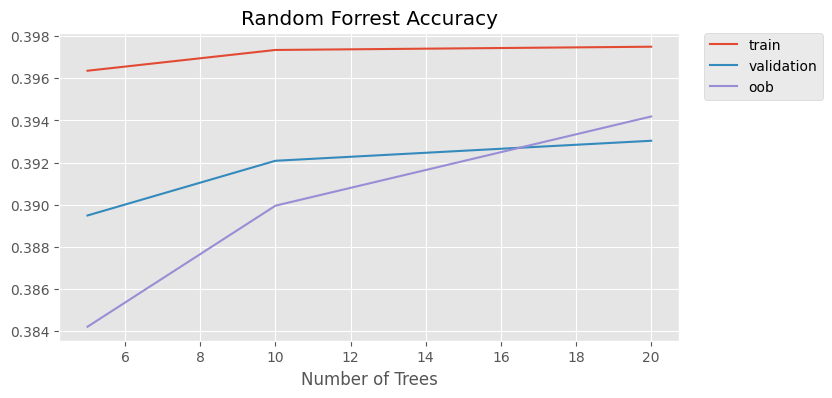

Features Ranked by Average Importance:

      Feature              Importance
 1. alpha_pb         (0.21153039165241136)
 2. alpha_atr14      (0.1812860293126141)
 3. alpha_075        (0.13301685392727605)
 4. alpha_122        (0.12368311576174308)
 5. alpha_atr        (0.09185735963967973)
 6. alpha_149        (0.07450669929920124)
 7. alpha_103        (0.06809570111962282)
 8. alpha_010        (0.0262095742502738)
 9. alpha_021        (0.01943578981214059)
10. alpha_089        (0.019235990618788692)
11. alpha_056        (0.01700827040729471)
12. alpha_kama       (0.011670111474230476)
13. sector_0         (0.011549407986057728)
14. alpha_083        (0.008808990947373743)
15. sector_1         (0.002105713791291966)
16. alpha_101        (0.0)
17. alpha_111        (0.0)
18. alpha_069        (0.0)
19. alpha_supertrend (0.0)


In [22]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=3):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [57]:
n_days = 40
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    #'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [5, 10]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 2/2 [00:03<00:00,  1.50s/Model]


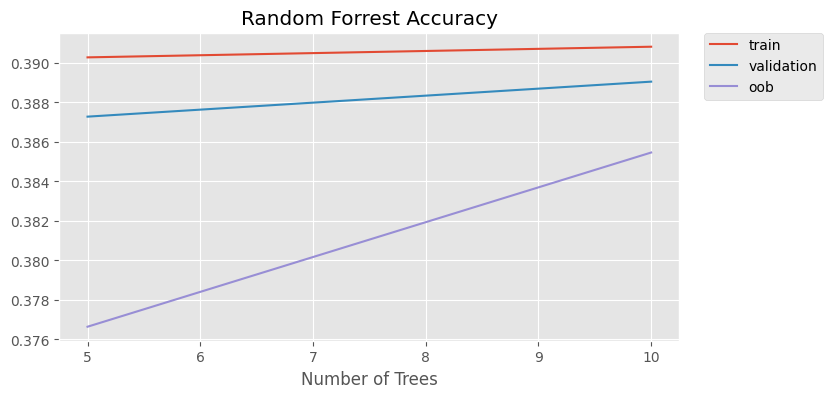

In [58]:
ph.plot(
    [n_trees_l]*5,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.3890506329113924
Precision score:  0.3890506329113924
Recall score:  0.3890506329113924
F1 score:  0.38905063291139236


In [60]:
factor_names = [ 
            'alpha_kama', 'alpha_atr14', 'alpha_083', 'alpha_103',  'alpha_111', 'alpha_021',
            #'alpha_pb',  'alpha_101', 'alpha_atr', 'alpha_010',  'alpha_supertrend',
            #'alpha_056', 'alpha_149', 'alpha_075', 'alpha_089','alpha_122', 'alpha_069'
            ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')

### Evalueate alpha factor

In [61]:
import alphalens as al
from scipy.stats import zscore

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    # only for long factor evaluate
    #for name in (factors + [alpha_score_label]):
    #    factors_with_alpha[name] = np.where(factors_with_alpha[name]>0, factors_with_alpha[name], 0.)
        
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing, holding_time=1)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 21.3% entries from factor data: 0.0% in forward returns computation and 21.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

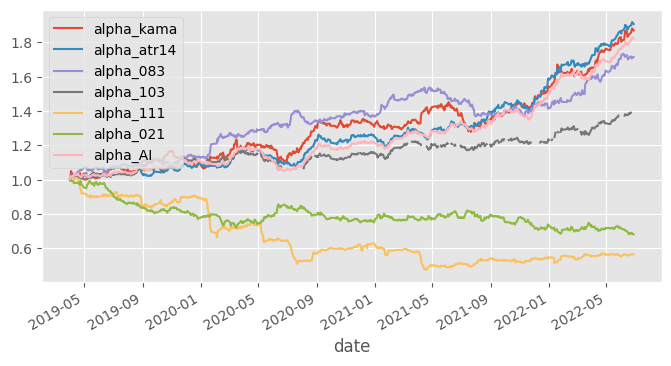

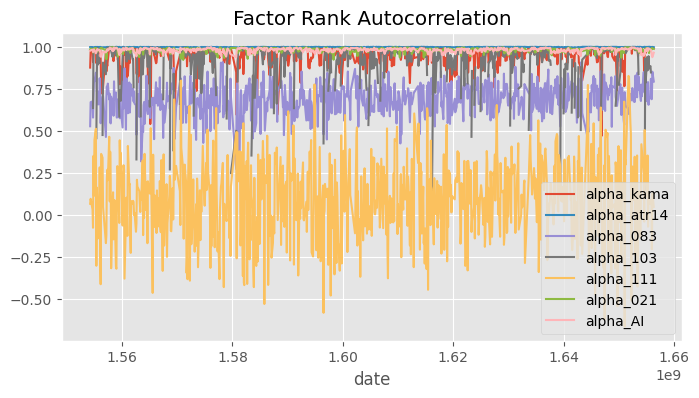

In [62]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 20.4% entries from factor data: 0.0% in forward returns computation and 20.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

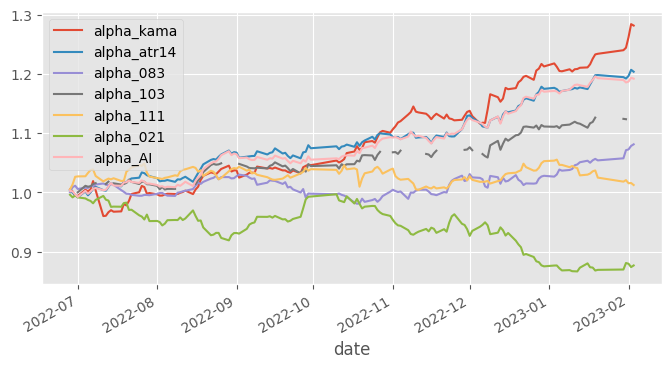

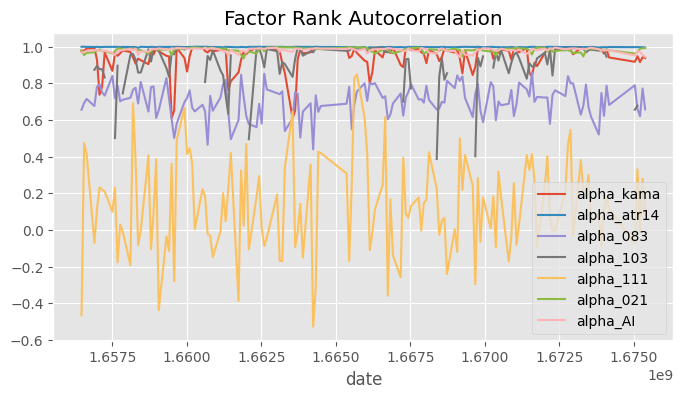

In [63]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [64]:
n_days = 40
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 10

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [65]:
print(train_score)
print(valid_score, oob_score)

[0.39323594156493896]
[0.3944303797468354] [0.3878604954209112]


### View Train Set Results

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 53.1% entries from factor data: 0.0% in forward returns computation and 53.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

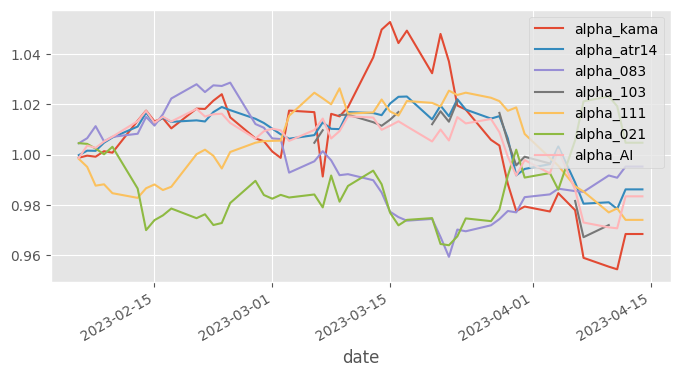

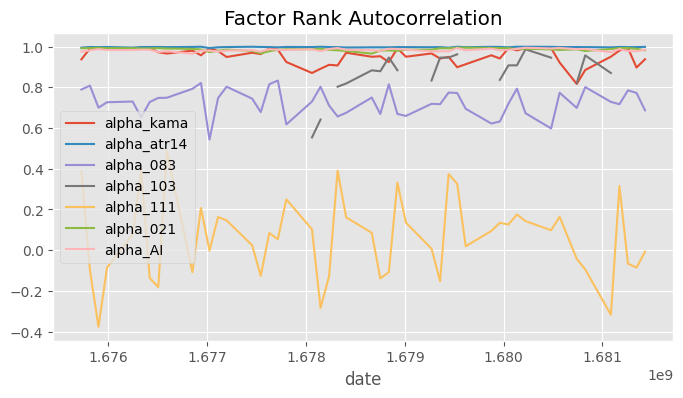

In [66]:
#show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 28.6% entries from factor data: 0.0% in forward returns computation and 28.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

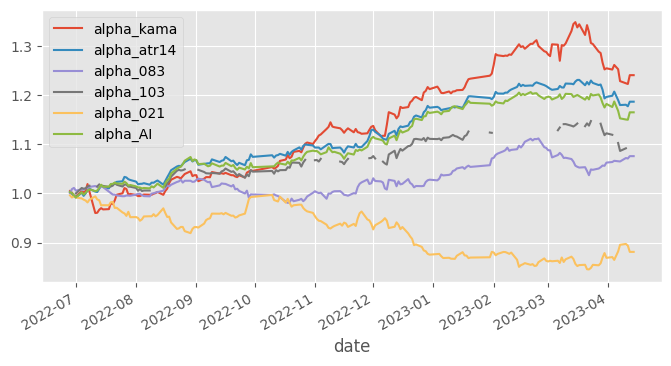

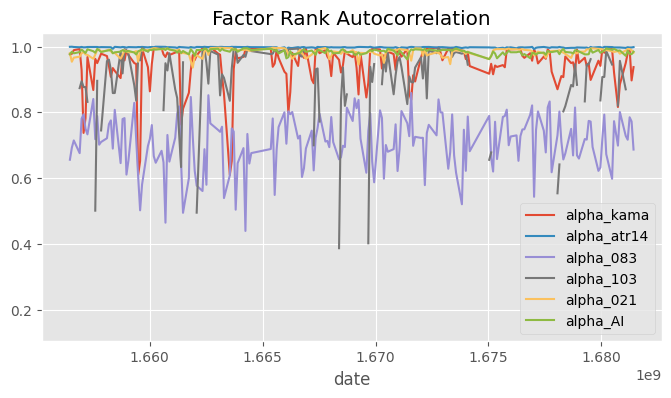

In [67]:
factor_names = [
           'alpha_kama', 'alpha_atr14', 'alpha_083', 'alpha_103',  'alpha_021', #'alpha_111', 
            #'alpha_pb',  'alpha_101', 'alpha_atr', 'alpha_010',  'alpha_supertrend',
            #'alpha_056', 'alpha_149', 'alpha_075', 'alpha_089','alpha_122', 'alpha_069'
           ]
#tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([X_valid, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [ ]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
#     factors_with_alpha = factors_with_alpha.reset_index()
#     factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
#     factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    return factors_with_alpha

sample_all = universe.reset_index()
sample_all.set_index(['date','ts_code']).sort_values(by=['date'])
save_factors = save_AI_factors(sample_all, clf_nov)
save_factors = save_factors.reset_index().set_index(['date'])
save_factors = universe.merge(save_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

In [ ]:
save_factors['alpha_AI'].hist()

In [ ]:
#save_factors['alpha_pb'] = -save_factors['pb']
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
         'alpha_atr14', 'alpha_kama', 'alpha_AI', 'alpha_083'
        ]
save_factors[field].to_csv('AI_data/factors_AI_108.csv')

### Save RandomForest Model

In [68]:
import joblib

joblib.dump(clf_nov, 'AI_data/clf_108.pkl')


['AI_data/clf_108.pkl']

Load model example

In [ ]:
clf_load = joblib.load('clf_20230401.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
print(alpha_score, len(alpha_score))